# Greedy para selección de proveedores

In [24]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cargar datos correctamente considerando la estructura específica del CSV
costos_proveedor = pd.read_csv('CostosEspeciesProveedores.csv', header=None)

# Extraer nombres de proveedores (primera fila, saltando primera celda que es NaN)
nombres_proveedores = costos_proveedor.iloc[0, 1:].tolist()

# Extraer nombres de especies (primera columna, saltando primera celda)
nombres_especies = costos_proveedor.iloc[1:, 0].tolist()

# Extraer matriz de costos (convertir a float)
matriz_costos = costos_proveedor.iloc[1:, 1:].values.astype(float)

# Definir constantes
costo_transporte = 4500
capacidad_máxima_transporte = 8000 # Capacidad máxima de transporte en conjunto de los proveedores
demanda_especies = [100, 200, 150, 300, 250, 700, 600, 80, 300]  # Demanda de cada especie
num_especies = len(demanda_especies)
num_proveedores = matriz_costos.shape[1]

# Verificar dimensiones
if num_especies != len(nombres_especies):
    print(f"¡Advertencia! El número de especies ({num_especies}) no coincide con los nombres disponibles ({len(nombres_especies)})")

In [26]:
def calcular_costo_total(solucion, matriz_costos, costo_transporte):
    """
    Calcula el costo total de una solución
    
    Args:
        solucion: Matriz donde cada fila es una especie y cada columna es un proveedor.
                 Los valores representan la cantidad de especies i compradas al proveedor j.
        matriz_costos: Matriz de costos unitarios de cada especie para cada proveedor
        costo_transporte: Costo de transporte por proveedor utilizado
    
    Returns:
        costo_total: Costo total de la solución
    """
    # Costo de compra de especies
    costo_compra = np.sum(solucion * matriz_costos)
    
    # Número de proveedores utilizados (si alguna especie > 0)
    proveedores_utilizados = np.sum(np.any(solucion > 0, axis=0))
    
    # Costo de transporte
    costo_trans = costo_transporte * proveedores_utilizados
    
    return costo_compra + costo_trans, costo_compra, costo_trans, proveedores_utilizados

def solucion_greedy(matriz_costos, demanda_especies):
    """
    Genera una solución greedy básica
    
    Args:
        matriz_costos: Matriz de costos unitarios de cada especie para cada proveedor
        demanda_especies: Lista con la demanda de cada especie
    
    Returns:
        solucion: Matriz de asignación de especies a proveedores
    """
    num_especies = len(demanda_especies)
    num_proveedores = matriz_costos.shape[1]
    
    # Inicializar matriz de solución con ceros
    solucion = np.zeros((num_especies, num_proveedores))
    
    # Para cada especie, elegir el proveedor más barato
    for especie in range(num_especies):
        # Ordenar proveedores por costo para esta especie
        proveedores_ordenados = np.argsort(matriz_costos[especie])
        
        # Asignar toda la demanda al proveedor más barato
        solucion[especie, proveedores_ordenados[0]] = demanda_especies[especie]
    
    return solucion

def analizar_solucion(solucion, matriz_costos, costo_transporte, 
                    nombres_especies=None, nombres_proveedores=None):
    """
    Analiza y muestra información detallada sobre una solución
    
    Args:
        solucion: Matriz de asignación de especies a proveedores
        matriz_costos: Matriz de costos unitarios
        costo_transporte: Costo por proveedor usado
        nombres_especies: Lista de nombres de especies (opcional)
        nombres_proveedores: Lista de nombres de proveedores (opcional)
        
    Returns:
        costo_total, num_proveedores, costo_compra, costo_trans
    """
    costo_total, costo_compra, costo_trans, num_proveedores = calcular_costo_total(
        solucion, matriz_costos, costo_transporte)
    
    proveedores_usados = np.any(solucion > 0, axis=0)
    
    print("\n--- Análisis de Solución Greedy ---")
    print(f"Costo total: {costo_total:.2f}")
    print(f"Costo de compra: {costo_compra:.2f}")
    print(f"Costo de transporte: {costo_trans:.2f}")
    print(f"Número de proveedores utilizados: {num_proveedores}")
    
    # Mostrar qué proveedores se usan
    print("\nProveedores utilizados:")
    for i, usado in enumerate(proveedores_usados):
        if usado:
            if nombres_proveedores and i < len(nombres_proveedores):
                nombre = nombres_proveedores[i]
            else:
                nombre = f"Proveedor {i}"
            print(f"- {nombre}")
    
    # Detallar la distribución de la compra
    print("\n--- Distribución Detallada de Compras ---")
    num_especies = solucion.shape[0]
    num_proveedores = solucion.shape[1]
    
    for especie in range(num_especies):
        if nombres_especies and especie < len(nombres_especies):
            nombre_especie = nombres_especies[especie]
        else:
            nombre_especie = f"Especie {especie}"
        
        print(f"\n{nombre_especie}:")
        for proveedor in range(num_proveedores):
            if solucion[especie, proveedor] > 0:
                if nombres_proveedores and proveedor < len(nombres_proveedores):
                    nombre_proveedor = nombres_proveedores[proveedor]
                else:
                    nombre_proveedor = f"Proveedor {proveedor}"
                
                print(f"  - Comprar {int(solucion[especie, proveedor])} unidades a {nombre_proveedor} " +
                      f"(costo unitario: {matriz_costos[especie, proveedor]:.2f})")
    
    return costo_total, num_proveedores, costo_compra, costo_trans

def visualizar_distribucion(solucion, nombres_especies=None, nombres_proveedores=None):
    """
    Visualiza la distribución de compras por especie y proveedor
    
    Args:
        solucion: Matriz de asignación de especies a proveedores
        nombres_especies: Lista de nombres de especies (opcional)
        nombres_proveedores: Lista de nombres de proveedores (opcional)
    """
    num_especies = solucion.shape[0]
    num_proveedores = solucion.shape[1]
    
    plt.figure(figsize=(12, 8))
    
    # Crear una máscara para valores mayores a cero
    mask = solucion > 0
    
    # Crear etiquetas para el heatmap
    if nombres_especies and len(nombres_especies) == num_especies:
        rows = nombres_especies
    else:
        rows = [f"Especie {i}" for i in range(num_especies)]
        
    if nombres_proveedores and len(nombres_proveedores) == num_proveedores:
        cols = nombres_proveedores
    else:
        cols = [f"Proveedor {i}" for i in range(num_proveedores)]
    
    # Crear un dataframe para seaborn
    df = pd.DataFrame(solucion, index=rows, columns=cols)
    
    # Crear heatmap
    sns.heatmap(df, annot=True, fmt='.0f', cmap='YlGnBu', mask=(~mask))
    plt.title('Distribución de Compras por Especie y Proveedor')
    plt.tight_layout()
    plt.show()

def ejecutar_greedy(matriz_costos, demanda_especies, costo_transporte,
                   nombres_especies=None, nombres_proveedores=None, visualizar=True):
    """
    Función principal para ejecutar el algoritmo greedy de selección de proveedores
    
    Args:
        matriz_costos: Matriz de costos unitarios de cada especie para cada proveedor
        demanda_especies: Lista con la demanda de cada especie
        costo_transporte: Costo de transporte por proveedor utilizado
        nombres_especies: Lista de nombres de especies (opcional)
        nombres_proveedores: Lista de nombres de proveedores (opcional)
        visualizar: Booleano para indicar si se debe mostrar la visualización
        
    Returns:
        solucion: Matriz de asignación de especies a proveedores
        costo_total: Costo total de la solución
    """
    # Generar solución greedy
    solucion = solucion_greedy(matriz_costos, demanda_especies)
    
    # Analizar la solución
    costo_total, _, _, _ = analizar_solucion(
        solucion, matriz_costos, costo_transporte,
        nombres_especies, nombres_proveedores
    )
    
    # Visualizar la solución
    if visualizar:
        visualizar_distribucion(solucion, nombres_especies, nombres_proveedores)
    
    return solucion, costo_total


--- Análisis de Solución Greedy ---
Costo total: 68270.00
Costo de compra: 50270.00
Costo de transporte: 18000.00
Número de proveedores utilizados: 4

Proveedores utilizados:
- Vivero
- Moctezuma
- Proveedor 4
- Laguna Seca

--- Distribución Detallada de Compras ---

especie 1:
  - Comprar 100 unidades a Laguna Seca (costo unitario: 26.00)

especie 2:
  - Comprar 200 unidades a Moctezuma (costo unitario: 26.00)

especie 3:
  - Comprar 150 unidades a Proveedor 4 (costo unitario: 25.00)

especie 4:
  - Comprar 300 unidades a Moctezuma (costo unitario: 17.00)

especie 5:
  - Comprar 250 unidades a Proveedor 4 (costo unitario: 18.00)

especie 6:
  - Comprar 700 unidades a Proveedor 4 (costo unitario: 12.00)

especie 7:
  - Comprar 600 unidades a Proveedor 4 (costo unitario: 18.00)

especie 8:
  - Comprar 80 unidades a Vivero (costo unitario: 26.50)

especie 9:
  - Comprar 300 unidades a Vivero (costo unitario: 26.00)


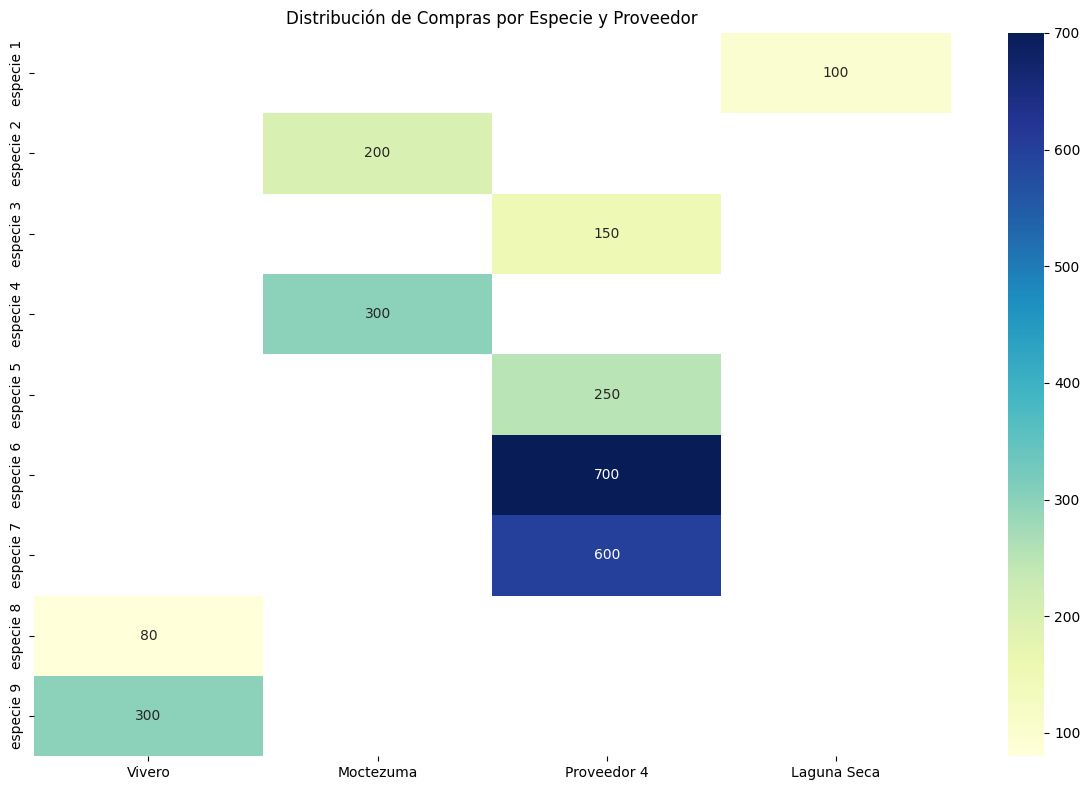


Costo total de la mejor solución: 68270.00


In [27]:
# Ejemplo de uso del algoritmo greedy parametrizado
if __name__ == "__main__":
    # Se pueden usar los datos ya cargados:
    mejor_solucion, mejor_costo = ejecutar_greedy(
        matriz_costos=matriz_costos,
        demanda_especies=demanda_especies,
        costo_transporte=costo_transporte,
        nombres_especies=nombres_especies,
        nombres_proveedores=nombres_proveedores
    )
    
    print(f"\nCosto total de la mejor solución: {mejor_costo:.2f}")
    
    # O se pueden proveer datos diferentes:
    '''
    # Ejemplo con datos personalizados
    matriz_costos_personalizada = np.array([
        [10, 20, 30],
        [15, 25, 5]
    ])
    
    demanda_personalizada = [100, 150]
    costo_transporte_personalizado = 5000
    
    nombres_especies_personalizados = ["Producto A", "Producto B"]
    nombres_proveedores_personalizados = ["Proveedor X", "Proveedor Y", "Proveedor Z"]
    
    solucion_personalizada, costo_personalizado = ejecutar_greedy(
        matriz_costos=matriz_costos_personalizada,
        demanda_especies=demanda_personalizada,
        costo_transporte=costo_transporte_personalizado,
        nombres_especies=nombres_especies_personalizados,
        nombres_proveedores=nombres_proveedores_personalizados
    )
    '''